In [ ]:
import sys
from google.colab import drive
import math
import pandas as pd
import csv
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
drive.mount('/content/drive')
sys.path += ['/content/drive/My Drive/COVID']
#from sklearn.linear_model import LinearRegression


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = "/content/drive/MyDrive/COVID/train_trendency.csv"
df_tend = pd.read_csv(path)

# path = "/content/drive/MyDrive/COVID/train_vaccine.csv"
# df_vac = pd.read_csv(path)

In [ ]:
class Regression:
    def __init__(self, m=1):
        """
        Least squares regression.
        
        Attributes
        --------------------
            coef_   -- numpy array of shape (m+1,)
                       estimated coefficients for the autoregression problem
            m_      -- integer
                       order for autoregression
        """

        self.coef_ = None
        self.m_ = m
    
    def fit(self, X, y):
        """
        Parameters
        --------------------
            X       -- numpy array of shape (n,m+1), features
            y       -- numpy array of shape (n,), targets
        Returns
        --------------------        
            self    -- an instance of self
        """
        #w= (X^T X)^{−1} X^T y
        XTX = np.dot(X.T, X)           #(X^T X)
        invXTX = np.linalg.pinv(XTX)   #(X^T X)^(-1)
        invXTX_XT = np.dot(invXTX, X.T)#(X^T X)^(-1) * X^T
        self.coef_ = np.dot(invXTX_XT, y)
        return self
        

    def predict(self, X):
        """
        Predict output for X. (using known values)
        
        Parameters
        --------------------
            X       -- numpy array of shape (n,m+1), features
        
        Returns
        --------------------
            y       -- numpy array of shape (n,), predictions
        """

        if self.coef_ is None:
            raise Exception("Model not initialized. Perform a fit first.")
        y = np.dot(X,self.coef_) #multiply X by w
        return y
    
    def guess(self, n, vals):
      m = self.m_
      result = []
      count = 0
      coefs = self.coef_[1:]
      intercept = self.coef_[0]
      while count < n:
        next_val = intercept + np.dot(coefs, vals[-m:])
        count += 1
        np.append(vals, [next_val])
      return vals[-n:]
      

In [ ]:
def generate_polynomial(X, m):
        pwrs = np.arange(0,m+1)
        return np.array([np.power(x,pwrs) for x in X[:,0]])

In [ ]:
def generate_lag_data(X, m=1):
  n = X.shape[0]
  Intercept = np.ones(n-m).reshape((n-m),1)
  Lag = np.array([X[p:p+m] for p in np.arange(0,X.size-m)])
  return np.hstack((Intercept, Lag))
# X = np.array([0,1,2,3,4,5])
# print(generate_lag_data(X, 2))
# print(X[2:])

In [ ]:
death_raw = {}
confirm = {}
sts = df_tend["Province_State"].unique()
for st in sts:
  death_raw[st] = df_tend.loc[df_tend["Province_State"] == st]["Deaths"].to_numpy()
  confirm[st] = df_tend.loc[df_tend["Province_State"] == st]["Confirmed"].to_numpy()


In [ ]:
POLY_ORDER_D = 2
DEATH_M = 40
POLY_ORDER_C = 3
CONFIRM_M=40

In [ ]:
death_reg = {}
confirm_reg ={}
death_fit = {}
confirm_fit = {}
for st in sts:
  X_D = generate_polynomial(np.arange(death_raw[st].size).reshape(-1, 1), POLY_ORDER_D)
  death_reg[st] = Regression(POLY_ORDER_D).fit(X_D, death_raw[st])
  death_fit[st] = death_raw[st] - death_reg[st].predict(X_D)
 
  X_C = generate_polynomial(np.arange(death_raw[st].size).reshape(-1, 1), POLY_ORDER_C)
  confirm_reg[st] = Regression(POLY_ORDER_C).fit(X_C, confirm[st])
  confirm_fit[st] = confirm[st] - confirm_reg[st].predict(X_C)

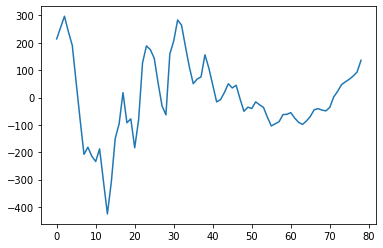

In [ ]:
plt.plot(death_fit["Alabama"])

In [ ]:

death_mod = {}
for st in sts:
  X_death = generate_lag_data(death_fit[st], DEATH_M)
  death_mod[st] = Regression(DEATH_M).fit(X_death, death_fit[st][DEATH_M:])


In [ ]:
death_results = {}
death_count = death_raw[st].size

for st in sts:
  X_D = generate_polynomial(np.arange(death_count, death_count+30).reshape(-1, 1), POLY_ORDER_D)
  death_results[st] = death_mod[st].guess(30, death_fit[st]) + death_reg[st].predict(X_D)
  #print(st)

In [ ]:
print(death_mod["Idaho"].coef_)

[0.34312869 0.75623352]


In [ ]:
confirm_mod = {}
for st in sts:
  X_confirm = generate_lag_data(confirm_fit[st], CONFIRM_M)
  confirm_mod[st] = Regression(CONFIRM_M).fit(X_confirm, confirm_fit[st][CONFIRM_M:])


In [ ]:
confirm_results = {}
confirm_count = confirm[st].size

for st in sts:
  X_C = generate_polynomial(np.arange(confirm_count, confirm_count+30).reshape(-1, 1), POLY_ORDER_C)
  confirm_results[st] = confirm_mod[st].guess(30, confirm_fit[st]) + confirm_reg[st].predict(X_C)
  #print(st)

In [ ]:
def MAPE(predicted, truth):
  n = predicted.size
  total = 0
  for i in range(n):
    total += abs(predicted[i] - truth[i])/abs(truth[i])
  return total/n

0.0434981484974158
0.020892117135980586
0.032195132816698196


In [ ]:
with open("/content/drive/MyDrive/COVID/submission.csv", 'w') as csvfile: 
    csvwriter = csv.writer(csvfile) 
        
    # writing the fields 
    csvwriter.writerow(["ID", "Confirmed", "Deaths"]) 
    id = 0
    for i in range(0,30):
      for st in sts:
        csvwriter.writerow([id, confirm_results[st][i], death_results[st][i]])
        id += 1

In [ ]:
print(confirm_results["Alabama"][0])

516885.86833803845
